#### This notebook contains statistical tests to assess the effect of ELS on freezing levels during PTSD induction (SEFL-A day) ####
The idea is separating ELS mice whether they got the 10x shock or not then running Mixed anova on them. 

In [ ]:
#installing a stat package
!pip install pingouin

     |████████████████████████████████| 183 kB 5.2 MB/s 
     |████████████████████████████████| 38.1 MB 2.9 MB/s 
     |████████████████████████████████| 9.8 MB 22.5 MB/s 
  Created wheel for pingouin: filename=pingouin-0.5.1-py3-none-any.whl size=194002 sha256=f53aeacf47f037fb0f7ed72bbfc9c4491ecc48b643e0438a16b7de40834c36fe
  Stored in directory: /root/.cache/pip/wheels/74/a7/b6/5b5f03b0395fdada1f45d3aed76e7da48873a02805545ef652
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=65f97a048bcc58a041bb95971d4f46ce24f296b989b9ea4bac3fba1db843d8a5
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built pingouin littleutils
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsm

You need to restart the Runtime after installing!

In [ ]:
from os.path import join
import sys
import glob

import matplotlib.pyplot as plt
import numpy as np
import pingouin as pg

# for slope calculation
from scipy.stats import linregress
from scipy.stats import ttest_ind
import seaborn as sns
# sns.set(font_scale = 1.5)
# sns.set_style("white")
import pandas as pd

%matplotlib inline

In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

from google.colab import drive
drive.mount('/content/drive')

save_dir = '/content/drive/Shareddrives/TuriLab/Data/PTSD_project/!analysis/saveFolder/'

Mounted at /content/drive


In [ ]:
df = pd.read_csv(join(save_dir,'els_and_age_matched_mice.csv'))
df.head(2)
# df.info()

#optional line. it will remove the "pre" column,
# i.e. the before shock freezing

# df.drop(labels=['pre'], axis=1, inplace=True)

,Unnamed: 0,group,els,sex,genotype,pre,shock01,shock02,shock03,shock04,shock05,shock06,shock07,shock08,shock09,shock10,cohort_id
0,87,Control,y,Male,wt,11.8,28.41,12.37,55.32,8.09,9.15,1.31,3.06,48.64,98.73,95.07,els1_922-1
1,88,Control,y,Male,wt,0.0,0.00,0.18,0.00,1.40,1.08,1.89,5.81,0.63,7.70,53.19,els1_922-2


Selecting ELS mice and making groups with equal number of mice

In [ ]:
df_els = df[df['els']=='y']
print('all mice in the ELS group:')
print(df_els.groupby('group')['cohort_id'].nunique())
print('===================\n')

df_equal = pd.concat([df_els[df_els['group']=='SEFL'],
                      df_els[df_els['group']=='Control'].sample(n=14,
                                                                random_state=4)])
print(f'selected mice:')
df_equal.groupby(['group'])['cohort_id'].nunique()
# df_equal[df_equal['group']=='Control']['cohort_id']

all mice in the ELS group:
group
Control    16
SEFL       14
Name: cohort_id, dtype: int64

selected mice:


group
Control    14
SEFL       14
Name: cohort_id, dtype: int64

Melting df to long form

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 <a list of 11 Text major ticklabel objects>)

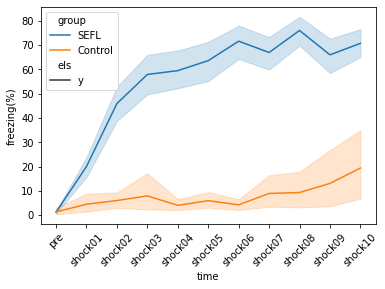

In [ ]:
melted_df = pd.melt(df_equal,
                    id_vars=['cohort_id', 'group', 'sex', 'genotype', 
                                       'els'],
                    value_vars=df.columns[4:-1],
                    var_name='time' )

# renaming one column
melted_df.rename(columns={0: "condition", 'value': 'freezing(%)'},
                 inplace=True)
# melted_df.head(4)
g = sns.lineplot(data=melted_df, x='time', y='freezing(%)',
             hue='group', style='els')
plt.xticks(rotation=45)

Running mixed ANOVA on groups

In [ ]:
#################
# mixed ANOVA   #
#################
res = pg.mixed_anova(data=melted_df, dv='freezing(%)',
                     between='group', within='time',
                     subject='cohort_id', correction=True)
res.round(3)

,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,group,168570.801,1,26,168570.801,187.666,0.0,NaN,0.878,NaN,NaN,NaN,NaN
1,time,49868.796,10,260,4986.880,43.604,0.0,0.0,0.626,0.269,False,0.0,0.0
2,Interaction,31009.434,10,260,3100.943,27.114,0.0,NaN,0.510,NaN,NaN,NaN,NaN


In [ ]:
melte

Running multiple t-tests to see where the significant diff is:

In [ ]:
pg.pairwise_ttests(data=melted_df, dv='freezing(%)', between='group',
                   within='time', subject='cohort_id').round(3)

,Contrast,time,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,time,-,pre,shock01,True,True,-5.614,27.0,two-sided,0.0,3469.708,-1.358
1,time,-,pre,shock02,True,True,-5.672,27.0,two-sided,0.0,3990.413,-1.502
2,time,-,pre,shock03,True,True,-5.731,27.0,two-sided,0.0,4615.071,-1.488
3,time,-,pre,shock04,True,True,-5.259,27.0,two-sided,0.0,1454.594,-1.391
4,time,-,pre,shock05,True,True,-5.559,27.0,two-sided,0.0,3029.588,-1.468
...,...,...,...,...,...,...,...,...,...,...,...,...
62,time * group,shock06,Control,SEFL,False,True,-18.051,26.0,two-sided,0.0,8.922e+12,-6.624
63,time * group,shock07,Control,SEFL,False,True,-11.609,26.0,two-sided,0.0,5.507e+08,-4.260
64,time * group,shock08,Control,SEFL,False,True,-13.449,26.0,two-sided,0.0,1.236e+10,-4.935
65,time * group,shock09,Control,SEFL,False,True,-6.744,26.0,two-sided,0.0,2.845e+04,-2.475


Selecting *only SEFL* mice and making groups with equal number of mice

In [ ]:
df_sefl = df[df['group']=='SEFL']
print(df_sefl.groupby('els')['cohort_id'].nunique())
print('===================\n')
# df_sefl.head()
print(f'equalized groups')
df_equal = pd.concat([df_sefl[df_sefl['els']=='n'],
                      df_sefl[df_sefl['els']=='y'].sample(n=13, random_state=3)])
df_equal.groupby(['els'])['cohort_id'].nunique()

els
n    13
y    14
Name: cohort_id, dtype: int64

equalized groups


els
n    13
y    13
Name: cohort_id, dtype: int64

Melting to long form

Text(0.5, 1.0, 'IS interval freezing els (n=13) vs. noELS (n=13)')

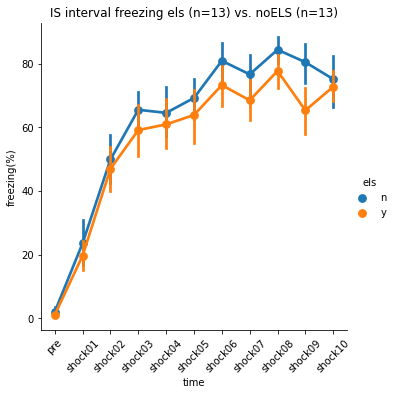

In [ ]:
melted_df = pd.melt(df_equal,
                    id_vars=['cohort_id', 'group', 'sex', 'genotype', 
                                       'els'],
                    value_vars=df.columns[4:-1],
                    var_name='time' )

# renaming one column
melted_df.rename(columns={0: "condition", 'value': 'freezing(%)'},
                 inplace=True)
# melted_df.tail(4)
g = sns.catplot(data=melted_df, x='time', y='freezing(%)',
             hue='els', kind='point')
plt.xticks(rotation=45)
num_mice = melted_df.groupby('els')['cohort_id'].nunique()
plt.title('IS interval freezing els (n={}) vs. noELS (n={})'.format(num_mice[0], num_mice[1]))

In [ ]:
#################
# mixed ANOVA   #
#################
res = pg.mixed_anova(dv='freezing(%)', between='els', within='time',
                     subject='cohort_id',data=melted_df, correction=True)
res.round(3)

,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,els,2354.548,1,24,2354.548,4.015,0.057,NaN,0.143,NaN,NaN,NaN,NaN
1,time,163768.297,10,240,16376.830,146.972,0.000,0.0,0.860,0.654,False,0.031,0.038
2,Interaction,968.496,10,240,96.850,0.869,0.563,NaN,0.035,NaN,NaN,NaN,NaN


running T-tests 

In [ ]:
pg.pairwise_ttests(data=melted_df, dv='freezing(%)', between='els',
                   within='time', subject='cohort_id').round(3)

,Contrast,time,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,time,-,pre,shock01,True,True,-9.811,25.0,two-sided,0.000,2.277e+07,-2.444
1,time,-,pre,shock02,True,True,-17.982,25.0,two-sided,0.000,6.679e+12,-4.752
2,time,-,pre,shock03,True,True,-21.992,25.0,two-sided,0.000,6.196e+14,-6.219
3,time,-,pre,shock04,True,True,-20.479,25.0,two-sided,0.000,1.23e+14,-5.583
4,time,-,pre,shock05,True,True,-21.929,25.0,two-sided,0.000,5.804e+14,-6.023
...,...,...,...,...,...,...,...,...,...,...,...,...
62,time * els,shock06,n,y,False,True,1.617,24.0,two-sided,0.119,0.931,0.614
63,time * els,shock07,n,y,False,True,1.667,24.0,two-sided,0.108,0.986,0.633
64,time * els,shock08,n,y,False,True,1.809,24.0,two-sided,0.083,1.169,0.687
65,time * els,shock09,n,y,False,True,2.851,24.0,two-sided,0.009,5.636,1.083


Selecting control mice

In [ ]:
df_ctrl= df[df['group']=='Control']
print(df_ctrl.groupby('els')['cohort_id'].nunique())
print('===================\n')
# df_ctrl.head()
print(f'equalized groups')
df_equal = pd.concat([df_ctrl[df_ctrl['els']=='n'],
                      df_ctrl[df_ctrl['els']=='y'].sample(n=10, random_state=4)])
df_equal.groupby(['els'])['cohort_id'].nunique()

els
n    10
y    16
Name: cohort_id, dtype: int64

equalized groups


els
n    10
y    10
Name: cohort_id, dtype: int64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 <a list of 11 Text major ticklabel objects>)

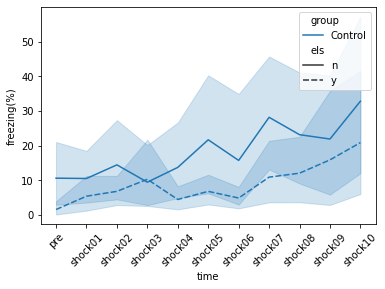

In [ ]:
melted_df = pd.melt(df_equal,
                    id_vars=['cohort_id', 'group', 'sex', 'genotype', 
                                       'els'],
                    value_vars=df.columns[4:-1],
                    var_name='time' )

# renaming one column
melted_df.rename(columns={0: "condition", 'value': 'freezing(%)'},
                 inplace=True)
# melted_df.tail(4)
g = sns.lineplot(data=melted_df, x='time', y='freezing(%)',
             hue='group', style='els')
plt.xticks(rotation=45)

In [ ]:
#################
# mixed ANOVA   #
#################
res = pg.mixed_anova(dv='freezing(%)', between='els', within='time',
                     subject='cohort_id',data=melted_df, correction=True)
res.round(3)

,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,els,4736.048,1,18,4736.048,1.737,0.204,NaN,0.088,NaN,NaN,NaN,NaN
1,time,7911.269,10,180,791.127,3.327,0.001,0.037,0.156,0.226,False,0.0,0.0
2,Interaction,1199.958,10,180,119.996,0.505,0.885,NaN,0.027,NaN,NaN,NaN,NaN


calculating t-test

In [ ]:
pg.pairwise_ttests(data=melted_df, dv='freezing(%)', between='els',
                   within='time', subject='cohort_id').round(3)

,Contrast,time,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,time,-,pre,shock01,True,True,-1.464,19.0,two-sided,0.159,0.584,-0.152
1,time,-,pre,shock02,True,True,-2.537,19.0,two-sided,0.020,2.88,-0.318
2,time,-,pre,shock03,True,True,-1.217,19.0,two-sided,0.238,0.443,-0.254
3,time,-,pre,shock04,True,True,-1.262,19.0,two-sided,0.222,0.465,-0.211
4,time,-,pre,shock05,True,True,-2.541,19.0,two-sided,0.020,2.901,-0.438
...,...,...,...,...,...,...,...,...,...,...,...,...
62,time * els,shock06,n,y,False,True,1.245,18.0,two-sided,0.229,0.679,0.533
63,time * els,shock07,n,y,False,True,1.716,18.0,two-sided,0.103,1.073,0.735
64,time * els,shock08,n,y,False,True,1.046,18.0,two-sided,0.309,0.582,0.448
65,time * els,shock09,n,y,False,True,0.435,18.0,two-sided,0.669,0.425,0.186
